<h2 style="color:blue"><b>Дискретное преобразование Фурье</b></h2>

<p>Прямое дискретное преобразование Фурье (медленное - O(N^2)) (<a href=https://habr.com/ru/companies/otus/articles/449996/>статья о ДПФ и БПФ хабр</a> и <a href=https://arhn.ru/articles/598190/>статья о ДПФ Julia</a>, и <a href=https://proglib.io/p/fourier-transform>статья о Фурье с геом. интерп.</a>) выглядит следующим образом:</p>
$$X[k]=\sum_{n=0}^{N-1}x[n] \cdot e^{-j \cdot \frac{2 \cdot \pi }{N}  \cdot n \cdot k},$$
<p>где x[n] $-$ сигнал во временной области (то что подается на вход функции).</p>
То есть имеется некоторый дискретный сигнал x[n] зависящий от времени и в каждую отметку времени измерена и записана некоторая величина, например, мы измерили частоту звукового сигнала в Герцах <i>(произвели дискретизацию сигнала с заданным шагом T..)</i>.
<br>
Приведем пример такого сигнала...

In [1]:
# Импортируем необходимые библиотеки
using Plots
using LinearAlgebra
# im - запись мнимой единицы в Julia
im*im

-1 + 0im

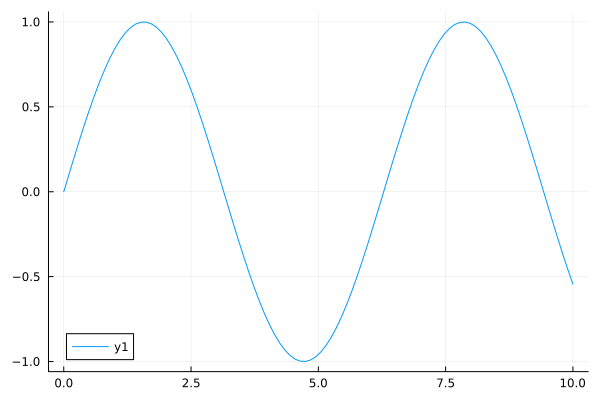

In [2]:
x = range(0, 10, length=100)
y = sin.(x)
plot(x, y)

Этот сигнал представлен в виде вектора размера N, где n $-$ это номер измерения этого сигнала (вектора).

In [3]:
N = length(y)
y_n = y[2]
println("N = ",N)
println("y[n] = ", y_n)

N = 100
y[n] = 0.1008384202581046


То есть если длина вектора <b>x</b>=[0,1,2,3] равна N=4, то при n=2 мы получим значение элемента x[2]=2 соответственно.<br>
Эта формула является верной и представлена в комплексном виде (о чем говорит нам экспонента и мнимая единица <i>j</i> в степени. Не забываем про Эйлера к тому же $e^{\pm j \cdot \phi} = cos(\phi) \pm j \cdot sin(\phi)$ и тождество $e^{j \cdot \pi } + 1 = 0$), потому что преобразование Фурье это с точки зрения математики, разложение на синусы и косинусы. В математике задача ставится таким образом, что есть некоторая непрерывная зависимость, которую можно описать с некоторой точностью рядом Фурье, определив 3 коэффициента: a, b, c. И там это всё представляется в интегральной форме соответственно. 
<br>
Широкоизвестен тригонометрический ряд Фурье (<a href=https://ru.wikipedia.org/wiki/%D0%A0%D1%8F%D0%B4_%D0%A4%D1%83%D1%80%D1%8C%D0%B5#%D0%A2%D1%80%D0%B8%D0%B3%D0%BE%D0%BD%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D1%8F%D0%B4_%D0%A4%D1%83%D1%80%D1%8C%D0%B5>например на Википедии<a/>):
$$f(x)=\frac{a_0}{2} + \sum_{n=1}^{\infty}\big(a_n \cdot \cos(n \cdot x) + b_n \cdot \sin(n \cdot x) \big),$$
где коэффициенты:

$$a_0 = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \cdot dx$$ <br>
$$a_n = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \cdot \cos(n \cdot x) \cdot dx$$ <br>
$$b_n = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \cdot \sin(n \cdot x) \cdot dx$$ <br>



<h3 style="color:orange">Немного сведений о формуле ДПФ</h3>
К тому же здесь в формуле ДПФ реализовано умножение матрицы на вектор ( матрица коэффициентов экспоненты $e^{-j \cdot \frac{2 \cdot \pi }{N}  \cdot n \cdot k}$ умножается на вектор x[n]). Причем эта матрица экспонент будет размером $n \times k$ (там умножение n=collect(0:N-1) на k=collect(0:N-1) происходит и получается матрица целых чисел). Также стоит заметить, что такая матрица будет создана единожды и умножится на вектор x. Это замечание позволяет нам оценить сложность работы программы.
X[k] $-$ это вектор, который мы получим на выходе. Переведем это из временной области в частотную так сказать. <br>
Взглянув на приведенное выше выражение ДПФ (DFT), мы видим, что это не более чем прямолинейная линейная операция: умножение матрицы на вектор:

$$\vec{X}=M \cdot \vec{x},$$
где 
$$M_{nk} = e^{-j \cdot \frac{2 \cdot \pi }{N}  \cdot n \cdot k}$$
Имея это в виду, мы можем вычислить ДПФ с использованием простого умножения матрицы.

Теперь можем перейти к созданию функции на ЯП julia...


In [4]:
# Сложность O(N^2)
function DFTslow(x::Array)
    # Compute the discrete Fourier Transform of the 1D array x

    N = length(x) # Размер x
    n = collect(0:N-1) # аналог arange(N)
    k = transpose(n) # можно менять оси или транспонировать просто
    nkMatrix = broadcast(*, n, k) # [0 1 2] * [0; 1; 2] = [0 0 0; 0 1 2; 0 2 4]
    M = exp.(-2im * π * nkMatrix / N) # строим матрицу вычисленных экспонент, по сути повороты

    return M * x # Умножаем матрицу (n,k) на вектор (1, n) и получаем Xk вектор

end # func

DFTslow (generic function with 1 method)

In [5]:
# На малых данных
x_little = Array([0.96604557, 0.2200642,  0.7233912])
DFTslow(x_little)

3-element Vector{ComplexF64}:
         1.90950097 + 0.0im
 0.4943178699999997 + 0.43589396841061007im
 0.4943178700000005 - 0.43589396841061057im

In [6]:
# На больших данных, звуковая волна...
y = Array(y) # конвертируем под стандартный массив
DFTslow(y)

100-element Vector{ComplexF64}:
     17.91931454924364 + 0.0im
     29.04068191102519 + 6.289868428098403im
   -31.874768023007015 - 14.067016219106993im
   -6.8007421988495675 - 4.647997938839769im
   -3.0968033036237355 - 2.956815954265577im
    -1.733833691174918 - 2.205442669404025im
   -1.0650537883054643 - 1.7688236424042474im
   -0.6833762059887677 - 1.4791865149821757im
   -0.4437814967180212 - 1.2711618549471728im
   -0.2830729503607277 - 1.1135718073304255im
  -0.16985615162956963 - 0.9895067829502209im
   -0.0870133779431988 - 0.8889392602715149im
 -0.024533752403436485 - 0.8055185022640774im
                       ⋮
 -0.024533752403429115 + 0.8055185022640337im
  -0.08701337794331836 + 0.8889392602715651im
  -0.16985615162975753 + 0.9895067829502064im
  -0.28307295036077734 + 1.113571807330381im
  -0.44378149671801237 + 1.2711618549472845im
   -0.6833762059887732 + 1.4791865149820598im
   -1.0650537883053781 + 1.768823642404227im
    -1.733833691174926 + 2.20544266940415im


In [7]:
Xk = DFTslow(y)
#plot(Xk)

100-element Vector{ComplexF64}:
     17.91931454924364 + 0.0im
     29.04068191102519 + 6.289868428098403im
   -31.874768023007015 - 14.067016219106993im
   -6.8007421988495675 - 4.647997938839769im
   -3.0968033036237355 - 2.956815954265577im
    -1.733833691174918 - 2.205442669404025im
   -1.0650537883054643 - 1.7688236424042474im
   -0.6833762059887677 - 1.4791865149821757im
   -0.4437814967180212 - 1.2711618549471728im
   -0.2830729503607277 - 1.1135718073304255im
  -0.16985615162956963 - 0.9895067829502209im
   -0.0870133779431988 - 0.8889392602715149im
 -0.024533752403436485 - 0.8055185022640774im
                       ⋮
 -0.024533752403429115 + 0.8055185022640337im
  -0.08701337794331836 + 0.8889392602715651im
  -0.16985615162975753 + 0.9895067829502064im
  -0.28307295036077734 + 1.113571807330381im
  -0.44378149671801237 + 1.2711618549472845im
   -0.6833762059887732 + 1.4791865149820598im
   -1.0650537883053781 + 1.768823642404227im
    -1.733833691174926 + 2.20544266940415im


Тогда амплитудный и фазовый спектры получим по формулам (<a href=https://www.fer.unizg.hr/_download/repository/LAB3[3].pdf>документ формулами</a>):
$$|X_k| = \sqrt{Re(X_k)^2+Im{X_k}^2}$$
$$arg(X_k) = arctan(Re(X_k) \cdot Im{X_k})$$

In [8]:
Amp = [sqrt(real(el)^2+imag(el)^2) for el in Xk]
Phase = [atan(real(el) * imag(el))  for el in Xk]

100-element Vector{Float64}:
  0.0
  1.5653217911170645
  1.5685660936852266
  1.53917115156047
  1.4620175020889516
  1.3150096173323311
  1.082800987501499
  0.79078932273734
  0.5136177982406547
  0.30536282403098347
  0.1665174807008924
  0.07719589930865298
  0.019759819345693538
  ⋮
 -0.01975981934568653
 -0.07719589930876297
 -0.16651748070107084
 -0.30536282403102233
 -0.5136177982406838
 -0.790789322737305
 -1.0828009875014608
 -1.3150096173323462
 -1.4620175020889572
 -1.5391711515604705
 -1.5685660936852264
 -1.5653217911170645

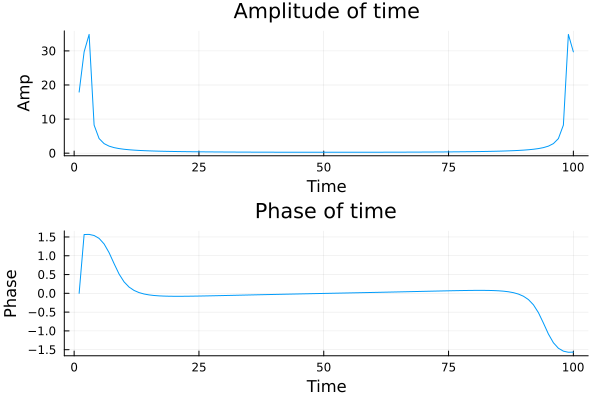

In [9]:
# Без fftshift(X) - https://www.mathworks.com/help/matlab/ref/fftshift.html
# Примеры графиков https://docs.juliaplots.org/latest/tutorial/
p1 = plot(Amp, title="Amplitude of time", xlabel="Time", ylabel="Amp")
p2 = plot(Phase, title="Phase of time", xlabel="Time", ylabel="Phase")
plot(p1, p2, layout=(2, 1), legend=false)

<h3 style="color:green">Оценка сложности ДПФ</h3>
Оценим сложность работы программы.
Необходимо сделать умножение строки на столбец это порядка N операций умножения (для одного k), для всех k получается N^2 операций умножения, после нужно еще сложить эти элементы.
Пример: Пусть есть матрица [[1 2], [3 4]] * [[1],[2]]  тогда умножение будет таким: [[1*1+2*2], [3*1 + 4*2]] = [[5],[11]]    <br>                                        
Получается N-1 сложений для одной строки на столбец и N*(N-1) для всех. Еще есть операции умножения в степени экспоненты, это порядка 4 операций и взятие экспоненты для каждого элемента матрицы n*k, это N^2. Тогда время T(N^2+N*(N-1)+4+N^2)=O(3*N^2)=O(N^2) (откидываем все константы и множители, N^2>>N поэтому тоже откидываем)<br>
Пространственная сложность. Если там 2 матрицы по коду я использую это уже 2*N^2 (матрица экспонент и буферная матрица экспонент) плюс входной и выходной вектора это 2*N, плюс переменные что-то будут занимать, их можно не учитывать. Тогда и пространственная сложность равна O(N^2).

In [10]:
time_sum() = @timed DFTslow(y)

time_sum (generic function with 1 method)

In [11]:
time_sum()

(value = ComplexF64[17.91931454924364 + 0.0im, 29.04068191102519 + 6.289868428098403im, -31.874768023007015 - 14.067016219106993im, -6.8007421988495675 - 4.647997938839769im, -3.0968033036237355 - 2.956815954265577im, -1.733833691174918 - 2.205442669404025im, -1.0650537883054643 - 1.7688236424042474im, -0.6833762059887677 - 1.4791865149821757im, -0.4437814967180212 - 1.2711618549471728im, -0.2830729503607277 - 1.1135718073304255im  …  -0.16985615162975753 + 0.9895067829502064im, -0.28307295036077734 + 1.113571807330381im, -0.44378149671801237 + 1.2711618549472845im, -0.6833762059887732 + 1.4791865149820598im, -1.0650537883053781 + 1.768823642404227im, -1.733833691174926 + 2.20544266940415im, -3.096803303623744 + 2.956815954265721im, -6.800742198849656 + 4.647997938839794im, -31.874768023006947 + 14.067016219106568im, 29.040681911025423 - 6.2898684280982895im], time = 0.000612807, bytes = 564704, gctime = 0.0, gcstats = Base.GC_Diff(564704, 4, 0, 7, 0, 0, 0, 0, 0))

In [12]:
r = rand(Int8, 5)
# DFTslow(r) work
# (@timed rand(Int8, 5)).bytes

5-element Vector{Int8}:
   89
   89
   47
  -66
 -110

In [13]:
function timeof()
    masTime = Float64[] # Для замера времени
    masBytes = Int64[] # Для замера памяти в байтах
    for size in range(1, 400)
        # println(i)
        r = rand(Int8, size)
        #t = [(@timed DFTslow(r)).time for _ in range(0, 1)] # измерения возьмем и усредним после
        ###b = [(@timed DFTslow(r)) for _ in range(0, 1)]
        #push!(masTime, (ones(length(t)) / length(t))'*t)
        ###push!(masBytes, (ones(length(b)) / length(b))'*b)
        time_bytes = @timed DFTslow(r)
        push!(masTime, time_bytes.time)
        push!(masBytes, time_bytes.bytes)
    end
    
    return masTime, masBytes
end

timeof (generic function with 1 method)

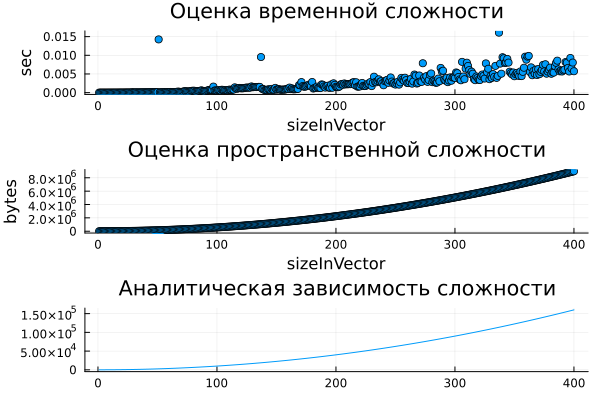

In [14]:
t_b = timeof()
pp1 = scatter(t_b[1], title="Оценка временной сложности", xlabel="sizeInVector", ylabel="sec")
pp2 = scatter(t_b[2], title="Оценка пространственной сложности", xlabel="sizeInVector", ylabel="bytes")
l = [N*N for N in range(1, 400)]
pp3analitics = plot(l, title="Аналитическая зависимость сложности")
plot(pp1, pp2, pp3analitics, layout=(3, 1), legend=false)